In [1]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from collections import deque

## Load Data
First, we load and format the news data and the financial data. The data is formatted so each entry in the financial data is kept as is, but the news data is concatenated to the indices in the financial data. The titles in the news data are concatenated to one string for every data point. 

In [2]:
# Path to the data-folder, files too large for git. 
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
news_data

,title
date,
2006-10-20,Exxon Mobil offers plan to end Alaska dispute
2006-10-20,"Hey buddy, can you spare $600 for a Google share?"
2006-10-21,AOL CEO says sales may shrink for two years -p...
2006-10-22,"Fed to keep hawkish tone, hold rates steady"
2006-10-21,Pluspetrol says losing $2.4 mln/day in Peru pr...
...,...
2013-11-19,JPMorgan agrees $13 billion settlement with U....
2013-11-19,"Dow, S&P retreat for second day; Best Buy weighs"
2013-11-19,"Bernanke: looking forward to writing, speaking..."


In [3]:
# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-19' : '2013-11-22']

In [5]:
concat_news = pd.DataFrame()
for date in news_data.index.drop_duplicates():
    temp_titles = ""
    for title in news_data.loc[date]['title']: 
        temp_titles += title + " "
    concat_news = concat_news.append({'date':date, 'title':temp_titles},ignore_index=True)
concat_news.set_index('date',inplace=True)
concat_news

,title
date,
2006-10-20,Exxon Mobil offers plan to end Alaska dispute ...
2006-10-21,AOL CEO says sales may shrink for two years -p...
2006-10-22,"Fed to keep hawkish tone, hold rates steady EU..."
2006-10-23,DaimlerChrysler talks to 2 firms on small car:...
2006-10-24,Options scandal hits 153 companies: US study J...
...,...
2013-11-15,Big Retailer is watching you: stores seek to m...
2013-11-16,Boeing says no plans to reopen union talks on ...
2013-11-17,Boeing launches new 777 with 259 orders Emirat...


In [32]:
# Find dates which there are news data and financial data for, and then determine if the index has gone up/down until that day
news_dates = concat_news.index.drop_duplicates()
valid_dates = np.arange(len(news_dates))[[date in fin_data.index for date in news_dates]]
fin_data.loc[news_dates[valid_dates]]

,1 YEAR,3 YEAR,S&P
date,,,
2006-10-20,5.05,4.80,2100.86
2006-10-23,5.09,4.84,2113.82
2006-10-24,5.10,4.84,2114.36
2006-10-25,5.08,4.79,2121.83
2006-10-26,5.06,4.74,2132.39
...,...,...,...
2013-11-13,0.13,0.61,3187.64
2013-11-14,0.13,0.56,3203.65
2013-11-15,0.13,0.58,3217.20


In [10]:
# Normalize the financial data to [0,1]
fin_data_norm = pd.DataFrame(columns=fin_data.columns) 
fin_stats = pd.DataFrame(columns=['min', 'max'],index=fin_data.columns)
for col in fin_data.columns:
    fin_stats.loc[col]['min'] = np.min(fin_data[col])
    fin_stats.loc[col]['max'] = np.max(fin_data[col])
    
for i in range(len(fin_data)): 
    temp_series = {}
    for col in fin_data.columns:
        temp_series.update({col: (fin_data.iloc[i][col] - fin_stats.loc[col]['min']) / (fin_stats.loc[col]['max'] - fin_stats.loc[col]['min'])})
    fin_data_norm = fin_data_norm.append(temp_series,ignore_index=True)
fin_data_norm.index = fin_data.index
fin_data_norm

,1 YEAR,3 YEAR,S&P
Date,,,
2006-10-19,0.986111,0.929897,0.469810
2006-10-20,0.986111,0.931959,0.471000
2006-10-23,0.994048,0.940206,0.477069
2006-10-24,0.996032,0.940206,0.477321
2006-10-25,0.992063,0.929897,0.480819
...,...,...,...
2013-11-18,0.009921,0.057732,0.988256
2013-11-19,0.011905,0.061856,0.985469
2013-11-20,0.007937,0.059794,0.980098


In [11]:
concat_news = pd.DataFrame()
for date in news_data.index.drop_duplicates():
    temp_titles = ""
    for title in news_data.loc[date]['title']: 
        temp_titles += title + " "
    concat_news = concat_news.append({'date':date, 'title':temp_titles},ignore_index=True)
concat_news.set_index('date',inplace=True)
concat_news

,title
date,
2006-10-20,Exxon Mobil offers plan to end Alaska dispute ...
2006-10-21,AOL CEO says sales may shrink for two years -p...
2006-10-22,"Fed to keep hawkish tone, hold rates steady EU..."
2006-10-23,DaimlerChrysler talks to 2 firms on small car:...
2006-10-24,Options scandal hits 153 companies: US study J...
...,...
2013-11-15,Big Retailer is watching you: stores seek to m...
2013-11-16,Boeing says no plans to reopen union talks on ...
2013-11-17,Boeing launches new 777 with 259 orders Emirat...


In [12]:
# Concatenate the news title up to the day in the financial index. 
data = pd.DataFrame(columns=['title'],index=['date'])
temp_titles = ""
for date in concat_news.index:
    temp_titles += concat_news.loc[date]['title'] + " "
    if date in fin_data_norm.index: 
        data = data.append({'date':date, 'title':temp_titles}, ignore_index=True)
        temp_titles = ""
data.set_index('date', inplace=True)
data = data.drop(data.index[0])

## Vectorize the data 
'CountVectorizer' from the sklearn-library is used to vectorize the data into frequency-vectors, i.e. how many times each word occurs in every day. The frequency matrix is then used as input to a Tfidf-vectorizer, which normalizes the vectors based on term vs document frequency.

In [13]:
# Create a matrix with the frequency of a word in each day.
count_vec = CountVectorizer()
count_vec.fit(data['title'])
x_count = count_vec.transform(data['title'])
print('Number of samples:',x_count.shape[0])
print('Size of the vocabulary:',x_count.shape[1])
print('Represantation of row 0:')
indices = np.where(x_count[0].todense() != 0)[1]
print("Word        Index")
for i in indices:
    print(count_vec.get_feature_names()[i],"     ",i)

Number of samples: 1846
Size of the vocabulary: 23571
Represantation of row 0:
Word        Index
600       575
alaska       1403
buddy       3577
can       3852
dispute       6633
end       7475
exxon       8029
for       8672
google       9434
hey       10120
mobil       13603
offers       14562
plan       15728
share       18878
spare       19683
to       21324
you       23465


In [14]:
# Create a matrix with the frequency of a word in each day.
tfidf_vec = TfidfTransformer()
tfidf_vec.fit(x_count)
x_tfidf = tfidf_vec.transform(x_count)
print('Number of samples:',x_tfidf.shape[0])
print('Size of the vocabulary:',x_tfidf.shape[1])
print('Representation of row 0:')
indices = np.where(x_tfidf[0].todense() != 0)[1]
print("Word      Value")
for i in indices: 
    print(count_vec.get_feature_names()[i],"     ",x_tfidf[0,i])

Number of samples: 1846
Size of the vocabulary: 23571
Representation of row 0:
Word      Value
600       0.23128611217246556
alaska       0.28466900768609965
buddy       0.41131744879090604
can       0.14778686826531356
dispute       0.20252761916821657
end       0.12276537461564675
exxon       0.2007720710541982
for       0.060483275600373795
google       0.13225041938075813
hey       0.4417160509489998
mobil       0.3205037223791542
offers       0.16457599923731622
plan       0.09938755586688157
share       0.14850126778512673
spare       0.34209978023216314
to       0.05957323851633483
you       0.28190065899355005


## Synchronize the data
We have prepared the news data with TF-IDF and normalized the financial data. We'll now create labels as the direction of the price change from the previous day. If the price today is higher, y = 1. If it is equal or lower, y = 0.

In [15]:
series = 'S&P'
y_binary = np.zeros(x_tfidf.shape[0])
for i in range(len(y_binary)): 
    if i < len(data) - 1:
        if fin_data_norm.loc[data.index[i]][series] < fin_data_norm.loc[data.index[i+1]][series]: 
            y_binary[i] = 1
        else: 
            y_binary[i] = 0
    else: 
        fin_idx = np.where(fin_data_norm.index == data.index[-1])[0][0]
        if fin_data_norm.iloc[fin_idx][series] < fin_data_norm.iloc[fin_idx + 1][series]: 
            y_binary[i] = 1
        else: 
            y_binary[i] = 0        

In [16]:
print("Shape of y:",y_binary.shape)
print("Shape of x:",x_tfidf.shape)

Shape of y: (1846,)
Shape of x: (1846, 23571)


In [61]:
# Shuffle and partition into training and test set (non-sequential data)
zero_indices = np.where(y_binary == 0)[0]
np.random.shuffle(zero_indices)
one_indices = np.where(y_binary == 1)[0]
np.random.shuffle(one_indices)

n_train = 1000
n_test = len(y_binary) - n_train

train_indices = np.zeros((n_train),dtype=int)
train_indices[:int(n_train / 2)] = zero_indices[:int(n_train / 2)]
train_indices[int(n_train / 2):] = one_indices[:int(n_train / 2)]
np.random.shuffle(train_indices)

test_indices = np.setdiff1d(np.arange(len(y_binary)), train_indices)
np.random.shuffle(test_indices)

x_train = x_tfidf[train_indices].todense()
y_train = y_binary[train_indices]

x_test = x_tfidf[test_indices].todense()
y_test = y_binary[test_indices]

print("Shape of x,y train:",x_train.shape, y_train.shape)
print("Shape of x,y test:",x_test.shape, y_test.shape)

Shape of x,y train: (1000, 23571) (1000,)
Shape of x,y test: (846, 23571) (846,)


In [62]:
# Shuffle and partition into training and test set (sequential data)
lookback = 3
x_seq = np.zeros((x_tfidf.shape[0] - lookback + 1, lookback, x_tfidf.shape[-1]))
prev_data = deque(maxlen=lookback)
index = 0
for i,row_tfidf in enumerate(x_tfidf): 
    row = np.asarray(row_tfidf.todense()).reshape(x_tfidf.shape[-1])
    prev_data.append(row)
    if len(prev_data) == lookback: 
        x_seq[index,:] = np.asarray(prev_data)
        index += 1
y_seq = y_binary[lookback - 1 :]


indices = np.arange(len(y_seq))
np.random.shuffle(indices)
n_train = 1400

x_seq_train = x_seq[indices[:n_train]]
y_seq_train = y_seq[indices[:n_train]]

x_seq_test = x_seq[indices[n_train:]]
y_seq_test = y_seq[indices[n_train:]]

print("Shape of x,y train:",x_seq_train.shape, y_seq_train.shape)
print("Shape of x,y test:",x_seq_test.shape, y_seq_test.shape)

Shape of x,y train: (1400, 3, 23571) (1400,)
Shape of x,y test: (444, 3, 23571) (444,)


## Train and evaluate models 
A few different models are trained and compared, namely: 
 - Logistic regression 
 - Random Forest
 - XGBoost
 - Neural Network
 The regular data is used for the first three models, and the sequential data is used for the neural network. It is however only a regular feed-forward network, so multi-dimensional is probably a better wording than sequential. 

In [63]:
def plot_results(model,x_test, y_test):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    plt.show()
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Test distribution')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    

def plot_results_nn(history, model):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    plt.show() 
    y_seq_test_pred = np.round(model.predict(x_seq_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_seq_test == 0), np.sum(y_seq_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_seq_test_pred == 0), np.sum(y_seq_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_seq_test,y_seq_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    print(classification_report(y_seq_test, y_seq_test_pred))
    print("Test accuracy:",model.evaluate(x_seq_test, y_seq_test, verbose=0)[1])

## Random Classifier
Just for real simple comparison. 

              precision    recall  f1-score   support

         0.0       0.43      0.50      0.46       358
         1.0       0.58      0.52      0.55       488

    accuracy                           0.51       846
   macro avg       0.51      0.51      0.51       846
weighted avg       0.52      0.51      0.51       846

Test accuracy: 0.4988179669030733


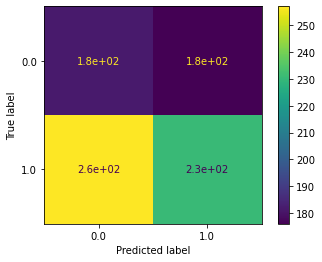

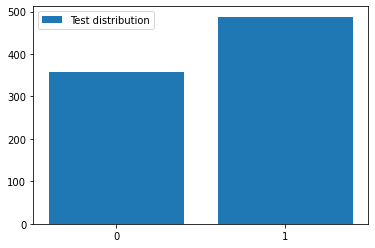

In [74]:
# Dummy Classifier
dummy_clf = DummyClassifier().fit(x_train, y_train)
plot_results(dummy_clf, x_test, y_test)

## Logistic Regression

              precision    recall  f1-score   support

         0.0       0.43      0.49      0.46       358
         1.0       0.58      0.51      0.54       488

    accuracy                           0.50       846
   macro avg       0.50      0.50      0.50       846
weighted avg       0.51      0.50      0.51       846

Test accuracy: 0.5035460992907801


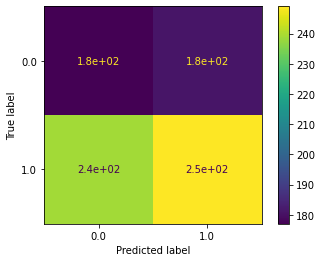

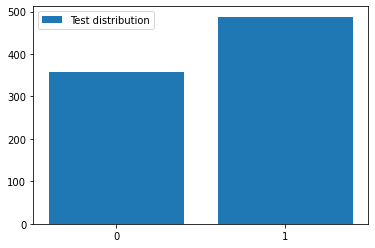

In [81]:
# Logistic regression
logreg = LogisticRegression(random_state=0).fit(x_train, y_train)
plot_results(logreg,x_test, y_test)

### Results Logistic Regression
Logistic regression yields a weighted f1-score of 0.51. 

## Random Forest

In [115]:
# Random Forest

rf_param_grid = dict(max_depth=[None, 10, 50, 100, 500],
                  n_estimators=[50, 100, 250, 500, 1000, 5000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=3, 
                       scoring='f1_weighted',
                       verbose=1)
rf_grid_result = rf_grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 13.0min finished


Best: 0.504920 using {'max_depth': None, 'n_estimators': 250}
0.498471 (0.005008) with: {'max_depth': None, 'n_estimators': 50}
0.492100 (0.004017) with: {'max_depth': None, 'n_estimators': 100}
0.504920 (0.009427) with: {'max_depth': None, 'n_estimators': 250}
0.492854 (0.009209) with: {'max_depth': None, 'n_estimators': 500}
0.468960 (0.022785) with: {'max_depth': None, 'n_estimators': 1000}
0.481448 (0.012154) with: {'max_depth': None, 'n_estimators': 5000}
0.468625 (0.035956) with: {'max_depth': 10, 'n_estimators': 50}
0.464030 (0.011539) with: {'max_depth': 10, 'n_estimators': 100}
0.493025 (0.019106) with: {'max_depth': 10, 'n_estimators': 250}
0.485273 (0.007785) with: {'max_depth': 10, 'n_estimators': 500}
0.487810 (0.024403) with: {'max_depth': 10, 'n_estimators': 1000}
0.485261 (0.019796) with: {'max_depth': 10, 'n_estimators': 5000}
0.482441 (0.017338) with: {'max_depth': 50, 'n_estimators': 50}
0.496207 (0.023481) with: {'max_depth': 50, 'n_estimators': 100}
0.480853 (0.013

              precision    recall  f1-score   support

         0.0       0.42      0.49      0.45       358
         1.0       0.57      0.50      0.53       488

    accuracy                           0.49       846
   macro avg       0.49      0.49      0.49       846
weighted avg       0.50      0.49      0.50       846

Test accuracy: 0.4929078014184397


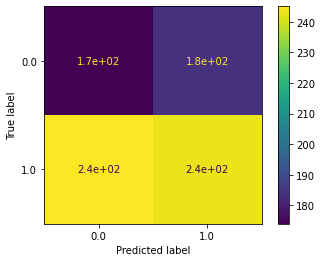

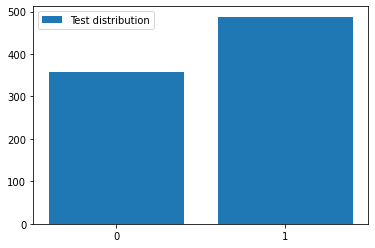

In [116]:
# Fit the model with the best parameters found in the cross validation. 
randomforest = RandomForestClassifier(n_estimators=rf_grid_result.best_params_['n_estimators'],
                                      max_depth=rf_grid_result.best_params_['max_depth'],
                                     ).fit(x_train, y_train)
plot_results(randomforest,x_test, y_test)

### Results Random Forest 
Optimizing over the estimators (50, 100, 250, 500, 1000, 5000) gives a weighted average f1-score 0.53 for the best configuration with 50 estimators. It does however vary quite a bit for different runs. 

## XGBoost

In [123]:
# XGBoost
xg_param_grid = dict(max_depth=[2, 3, 5, 10],
                     n_estimators=[50, 100, 250, 500],
                     learning_rate=[0.1, 0.01, 0.001])
xg_grid = GridSearchCV(estimator=XGBClassifier(), 
                       param_grid=xg_param_grid, 
                       n_jobs=-1, 
                       cv=3, 
                       scoring='f1_weighted',
                       verbose=5)
xg_grid_result = xg_grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (xg_grid_result.best_score_, xg_grid_result.best_params_))
xg_means = xg_grid_result.cv_results_['mean_test_score']
xg_stds = xg_grid_result.cv_results_['std_test_score']
xg_params = xg_grid_result.cv_results_['params']
for mean, stdev, param in zip(xg_means, xg_stds, xg_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 82.2min finished


Best: 0.500840 using {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
nan (nan) with: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 50}
nan (nan) with: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100}
nan (nan) with: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 250}
nan (nan) with: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500}
0.480192 (0.010359) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
0.475815 (0.004649) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
0.486787 (0.007966) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 250}
0.485792 (0.026771) with: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 500}
0.492536 (0.009035) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.493868 (0.007595) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.485831 (0.011744) with: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
0.50

              precision    recall  f1-score   support

         0.0       0.41      0.49      0.45       358
         1.0       0.57      0.49      0.52       488

    accuracy                           0.49       846
   macro avg       0.49      0.49      0.49       846
weighted avg       0.50      0.49      0.49       846

Test accuracy: 0.48936170212765956


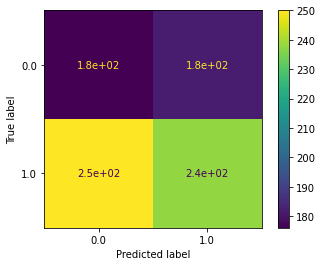

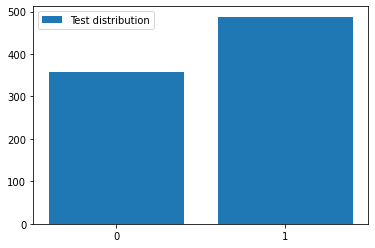

In [124]:
# Fit the model with the best parameters found in the cross validation. 
xgb = XGBClassifier(max_depth=xg_grid_result.best_params_['max_depth'],
                     n_estimators=xg_grid_result.best_params_['n_estimators'],
                     learning_rate=xg_grid_result.best_params_['learning_rate']).fit(x_train, y_train)
plot_results(xgb,x_test, y_test)

### Results XGBoost

XGBoost gives a slightly worse weighted f1-score to the Random Forest-model with 0.49 using 250 estimators, which was the best of the tested (50, 100, 250, 500, 1000, 5000). The variation between runs is however quite large.


## Neural Network

In [125]:
def create_model(nodes=100, dropout_rate=0.3):
    model = Sequential() 
    model.add(Dense(nodes, input_shape=x_seq_train.shape[1:]))
    model.add(Flatten())
    model.add(Dense(nodes))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
    return model 

### Hyperparameters Grid Search
Optimize with respect to batch size, epochs, nodes and dropout rate. Two layers are used. 

In [90]:
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [8,16, 64]
depth = [1,2,3]
epochs = [3,4,5]
nodes = [10, 50, 100]
dropout_rates = [0.5]
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(batch_size=batch_size, epochs=epochs, nodes=nodes, dropout_rate=dropout_rates)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=10)
grid_result = grid.fit(x_seq_train, y_seq_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  75 out of  81 | elapsed:  6.6min remaining:   31.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  7.0min finished
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-

PermissionError: [WinError 32] Det går inte att komma åt filen eftersom den
används av en annan process: 'C:\\Users\\gusta\\AppData\\Local\\Temp\\joblib_memmapping_folder_11952_5566395708\\11952-1711934289736-06c114b9e3df4e8683851775db54c41a.pkl'

### Model Training
The model is trained using the hyperparameters found above. 

In [341]:
grid_result.best_params_

{'batch_size': 8, 'dropout_rate': 0.5, 'epochs': 4, 'nodes': 100}

In [346]:
model = create_model(nodes=grid_result.best_params_['nodes'],
                     dropout_rate=grid_result.best_params_['dropout_rate'])

earlystop = EarlyStopping(monitor='val_loss',
                          patience=2,
                          restore_best_weights=True)
                         

history = model.fit(x_seq_train, y_seq_train,
                    validation_split=0.2,
                    epochs=8,
                    batch_size=grid_result.best_params_['batch_size'],
                    verbose=1)

Train on 1120 samples, validate on 280 samples
Epoch 1/8
1120/1120 [==============================] - 3s 3ms/sample - loss: 0.6964 - acc: 0.5205 - val_loss: 0.7196 - val_acc: 0.4357
Epoch 2/8
1120/1120 [==============================] - 3s 3ms/sample - loss: 0.3177 - acc: 0.9464 - val_loss: 0.9343 - val_acc: 0.5393
Epoch 3/8
1120/1120 [==============================] - 4s 3ms/sample - loss: 0.0047 - acc: 1.0000 - val_loss: 1.3783 - val_acc: 0.4821
Epoch 4/8
1120/1120 [==============================] - 4s 3ms/sample - loss: 1.3880e-05 - acc: 1.0000 - val_loss: 1.7863 - val_acc: 0.4857
Epoch 5/8
1120/1120 [==============================] - 3s 3ms/sample - loss: 3.2002e-07 - acc: 1.0000 - val_loss: 1.9621 - val_acc: 0.4929
Epoch 6/8
1120/1120 [==============================] - 3s 3ms/sample - loss: 6.4641e-08 - acc: 1.0000 - val_loss: 2.0488 - val_acc: 0.4786
Epoch 7/8
1120/1120 [==============================] - 3s 3ms/sample - loss: 1.8745e-08 - acc: 1.0000 - val_loss: 2.0953 - val_acc:

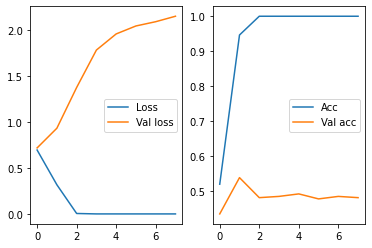

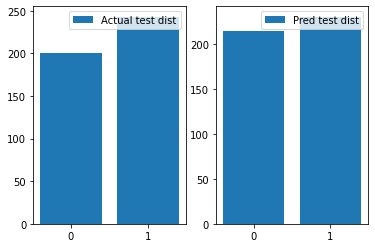

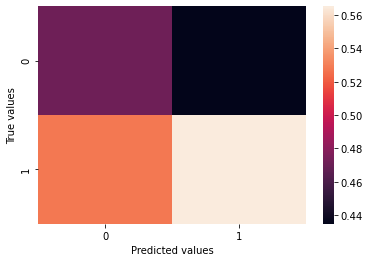

              precision    recall  f1-score   support

         0.0       0.47      0.50      0.49       201
         1.0       0.57      0.53      0.55       243

    accuracy                           0.52       444
   macro avg       0.52      0.52      0.52       444
weighted avg       0.52      0.52      0.52       444

Test accuracy: 0.5202703


In [366]:
plot_results_nn(history, model)

##  Summary
None of the models performed significantly better than the other, snce the variation between fittings was rather large. 

| Model | Weighted avg f1-score | Test Accuracy |
|------|------| ----|
| Logistic Regression  | 0.51 | 0.536 |
| Random Forest  | 0.51 | 0.513 |
| XGBoost  | 0.49 | 0.493 |
| Neural Network  | 0.52 | 0.520 |